In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

Dataset Shape: (1797, 64)
Number of Classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


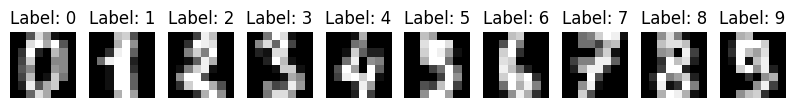

In [2]:
# Load the Digits Dataset
digits = load_digits()

# Features (X) and target (y)
X = digits.data
y = digits.target

# Display dataset information
print("Dataset Shape:", X.shape)
print("Number of Classes:", len(np.unique(y)))
print("Classes:", np.unique(y))

# Visualize some digits
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {digits.target[i]}")
plt.show()

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (scale pixel values to [0, 1])
X_train = X_train / 16.0
X_test = X_test / 16.0

In [9]:
# Train SVM model
svm_model = SVC(kernel='rbf', C=10.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

Accuracy: 0.99


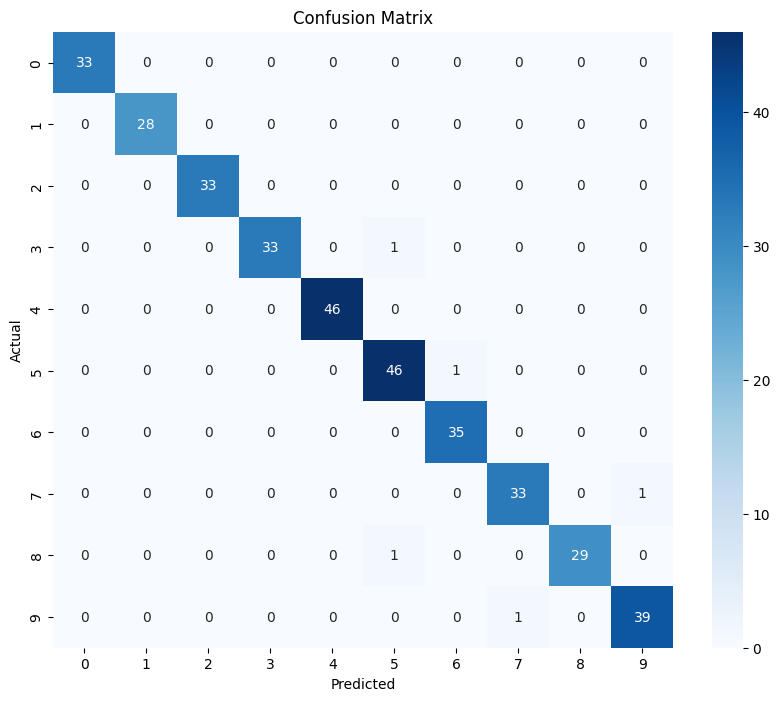

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       1.00      1.00      1.00        46
           5       0.96      0.98      0.97        47
           6       0.97      1.00      0.99        35
           7       0.97      0.97      0.97        34
           8       1.00      0.97      0.98        30
           9       0.97      0.97      0.97        40

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



In [10]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in digits.target_names])
print("Classification Report:\n", class_report)

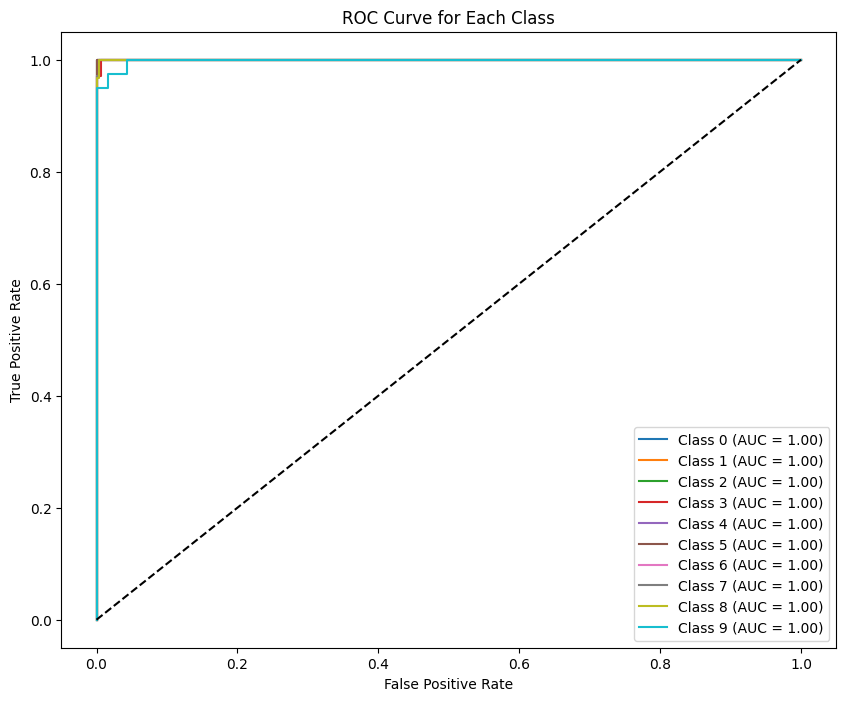

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Binarize the labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Train One-vs-Rest SVM for ROC curve
ovr_svm = OneVsRestClassifier(SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
ovr_svm.fit(X_train, label_binarize(y_train, classes=np.unique(y)))
y_score = ovr_svm.decision_function(X_test)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Perform Grid Search
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the best model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9916545683313978


SVC(C=10, probability=True, random_state=42)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [12]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 8, 8), dtype=torch.float32)  # Reshape to (N, C, H, W)
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 8, 8), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: (16, 8, 8)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Output: (32, 8, 8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, 4, 4)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
# Initialize the model, loss function, and optimizer
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
epochs = 30
for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = cnn_model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 2.0043
Epoch 2/30, Loss: 0.6502
Epoch 3/30, Loss: 0.2771
Epoch 4/30, Loss: 0.1807
Epoch 5/30, Loss: 0.1270
Epoch 6/30, Loss: 0.0977
Epoch 7/30, Loss: 0.0824
Epoch 8/30, Loss: 0.0690
Epoch 9/30, Loss: 0.0546
Epoch 10/30, Loss: 0.0422
Epoch 11/30, Loss: 0.0321
Epoch 12/30, Loss: 0.0283
Epoch 13/30, Loss: 0.0263
Epoch 14/30, Loss: 0.0212
Epoch 15/30, Loss: 0.0166
Epoch 16/30, Loss: 0.0147
Epoch 17/30, Loss: 0.0106
Epoch 18/30, Loss: 0.0091
Epoch 19/30, Loss: 0.0085
Epoch 20/30, Loss: 0.0059
Epoch 21/30, Loss: 0.0043
Epoch 22/30, Loss: 0.0036
Epoch 23/30, Loss: 0.0038
Epoch 24/30, Loss: 0.0055
Epoch 25/30, Loss: 0.0031
Epoch 26/30, Loss: 0.0026
Epoch 27/30, Loss: 0.0021
Epoch 28/30, Loss: 0.0020
Epoch 29/30, Loss: 0.0017
Epoch 30/30, Loss: 0.0022


In [16]:
# Evaluate the model
cnn_model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = cnn_model(X_batch)
        _, y_pred = torch.max(outputs, 1)
        y_pred_list.extend(y_pred.numpy())
        y_true_list.extend(y_batch.numpy())

# Calculate metrics
cnn_accuracy = accuracy_score(y_true_list, y_pred_list)
cnn_conf_matrix = confusion_matrix(y_true_list, y_pred_list)
cnn_class_report = classification_report(y_true_list, y_pred_list)

print("CNN Model Performance:")
print(f"Accuracy: {cnn_accuracy:.2f}")
print("Confusion Matrix:\n", cnn_conf_matrix)
print("Classification Report:\n", cnn_class_report)

CNN Model Performance:
Accuracy: 0.99
Confusion Matrix:
 [[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  1  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  0  0  0  0  0  1 39]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       0.98      1.00      0.99        46
           5       0.96      0.98      0.97        47
           6       0.97      0.97      0.97        35
           7       1.00      1.00      1.00        34
           8       0.97      0.97      0.97        30
           9       1.00      0.97      0.99    

In [17]:
# Create a comparison table
comparison = pd.DataFrame({
    "Model": ["SVM", "CNN"],
    "Accuracy": [accuracy, cnn_accuracy]
})
print(comparison)

  Model  Accuracy
0   SVM  0.986111
1   CNN  0.986111


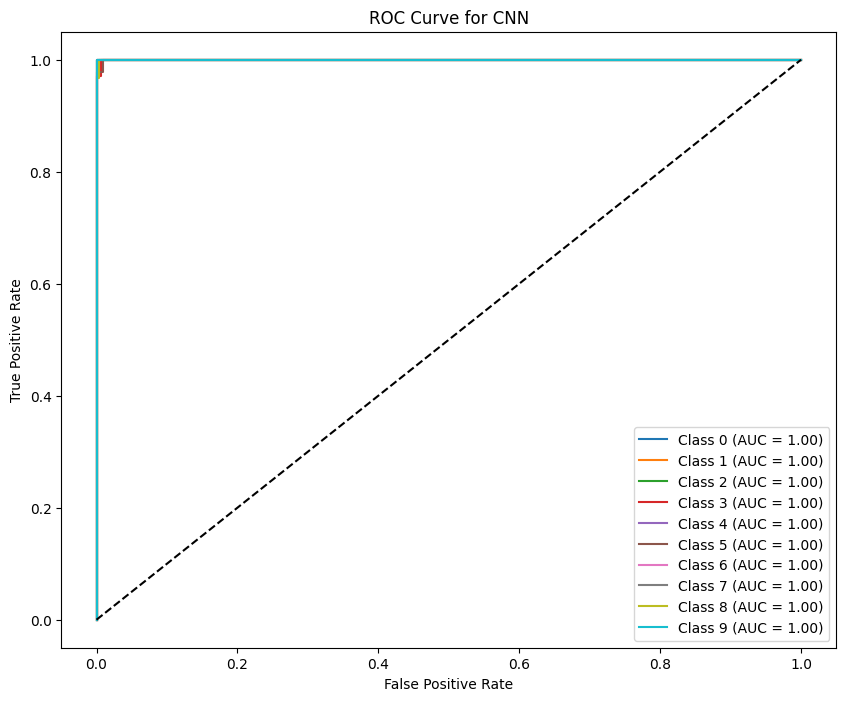

In [18]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_prob_cnn = []

cnn_model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = cnn_model(X_batch)
        y_pred_prob_cnn.extend(torch.softmax(outputs, dim=1).numpy())

y_pred_prob_cnn = np.array(y_pred_prob_cnn)

# Compute ROC curve and AUC for each class
fpr_cnn = {}
tpr_cnn = {}
roc_auc_cnn = {}
for i in range(n_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_cnn[i], tpr_cnn[i], label=f"Class {i} (AUC = {roc_auc_cnn[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CNN")
plt.legend(loc="lower right")
plt.show()